# **Tarea 3**

En este taller se trabajará sobre la modificación del juego de escaleras y serpientes del taller anterior. Utilizando el módulo desarrollado en el taller anterior.

Se definen las librerias requeridas

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from IPython.display import Image

Se tiene el problema dado por el juego de serpientes y escaleras dado en el taller 2

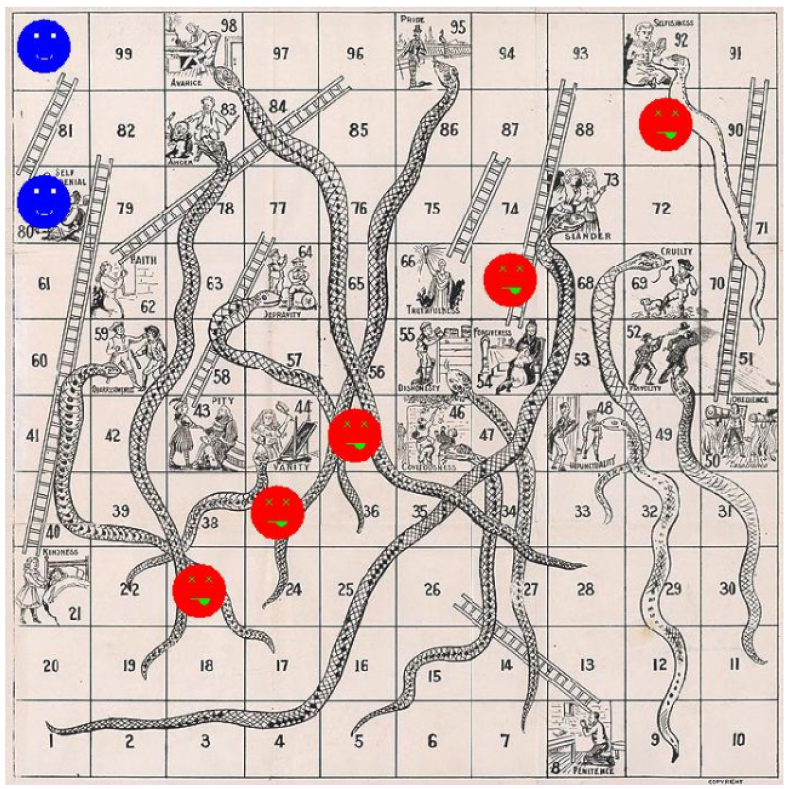

In [4]:
Image(filename='MDP.png')

A continuación, se definen dos diccionarios en Python que modelan las escaleras y serpientes del tablero, donde las claves representan las casillas de inicio y los valores indican las casillas destino. El diccionario escaleras indica las casillas donde un jugador avanza automáticamente a una posición más alta, mientras que serpientes representa las casillas que obligan al jugador a retroceder, dificultando su progreso. Estas transiciones no lineales afectan la dinámica del juego y se incorporan en la función de probabilidad de transición del MDP, asegurando que el modelo refleje correctamente las reglas del juego.

In [9]:
# Definir posiciones de escaleras y serpientes
escaleras = {8: 26, 21: 82, 43: 77, 50: 91, 54: 93, 66: 87, 62: 96} # modelado de 7 escaleras, la escalera que conecta los estados 80 y 100, por practicidad no se considera al ser ambos estados terminales de victoria.
serpientes = {52: 11, 69: 33, 92: 51, 48: 9, 73: 1, 55: 7, 46: 5, 95: 24, 64: 36, 44: 22, 98: 28, 83: 19, 59: 17} # modelado de serpientes

Se definen los parámetros iniciales del entorno y del algoritmo de Q-learning. El tablero tiene 100 casillas y los estados de victoria y derrota, estos representan celdas terminales que finalizan el episodio con una recompensa positiva o negativa, respectivamente. El agente puede tomar dos acciones: avanzar o retroceder, y se mueve según el resultado de un dado cargado (probabilidades), donde ciertos números tienen mayor probabilidad de aparecer. La lista de estados representa el espacio total del entorno, del 1 al 100. Finalmente, el aprendizaje se configura para realizar mil episodios, con una tasa de aprendizaje y un factor de descuento que indica que el agente valora significativamente las recompensas futuras.

In [10]:
# informacion inicial que se suministra en el enunciado
tamanoTablero = 100
gana = {80,100} #el usuario ingresa las celdas azules
pierde = {23, 37, 45, 67, 89} #el usuario ingresa la celdas rojas
acciones = [-1,1]
probabilidades = np.array([0.18, 0.2, 0.22, 0.18, 0.12, 0.1]) #se tiene un dado cargado
estados = np.arange(1, tamanoTablero+1) # se configura de esta manera para que vaya desde el 1 al 100
episodios=100000
alpha=0.03
gamma = 0.9
# epsilon = 0.1  # 10% de exploración

Se define una función que calcula el próximo estado en el juego de escaleras y serpientes considerando la acción elegida (avanzar o retroceder) y el resultado del dado. Si el estado actual es terminal, retorna el mismo estado. Luego, según la acción, suma o resta el valor del dado. Aplica una lógica de rebote cuando el estado excede los límites del tablero (mayor a 100 o menor a 1). Finalmente, si el nuevo estado corresponde a la base de una escalera o la cabeza de una serpiente, se actualiza automáticamente al estado resultante.

In [11]:
def transicionRecompensa(estado, accion, dado, escaleras, serpientes):
    # Movimiento inicial
    nuevoEstado = estado + (accion * dado)

    # Lógica de rebote
    if nuevoEstado < 1:
        nuevoEstado = abs(nuevoEstado) + 1
    elif nuevoEstado > 100:
        if estado == 99 and dado in [1, 2]:
            nuevoEstado = 100
        else:
            exceso = nuevoEstado - 100
            nuevoEstado = 100 - exceso

    # Aplicar efecto de escaleras o serpientes
    if nuevoEstado in serpientes:
        nuevoEstado = serpientes[nuevoEstado]
    elif nuevoEstado in escaleras:
        nuevoEstado = escaleras[nuevoEstado]

    # Asignación de recompensa
    if nuevoEstado in pierde:
        recompensa = -100
    elif nuevoEstado in gana:
        recompensa = 100
    else:
        recompensa = -1

    return nuevoEstado, recompensa

## _Punto 1:_

#### Escriba un método que implemente el algoritmo SARSA on-policy.

Se define una función que, inicializa la tabla Q con valores cero para cada acción posible en cada estado, y estructuras auxiliares para registrar el historial de aprendizaje y un contador que cuantifica las veces se visita cada estado. 

Se configura una política de comportamiento ε-greedy controlada por un valor epsilon que disminuye gradualmente con los episodios. En cada episodio, el agente comienza en el estado 1, elige una acción inicial según su política ε-greedy, y sigue interactuando con el entorno mientras no llegue a un estado terminal. Para cada paso, calcula la nueva acción a partir del nuevo estado usando también ε-greedy, y luego actualiza el valor Q(s,a) según la fórmula de SARSA:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma \, Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t) \right]
$$


donde $a_{t+1}$, es la acción futura estimada desde el nuevo estado. Luego actualiza el estado y acción actuales, repitiendo el ciclo. Al final de cada episodio, guarda la evolución del valor Q para ciertos estados seleccionados (por análisis). 

Tras completar todos los episodios, deriva la política óptima aprendida seleccionando la acción con mayor valor Q para cada estado no terminal, y devuelve la tabla Q, la política, el historial de evolución y las visitas por estado.

In [61]:
def sarsa(transicionFunc):
    Q = defaultdict(lambda: {-1: 0.0, 1: 0.0})
    historial = defaultdict(list)
    visitasEstado = defaultdict(int)
    politicaOptima = {}

    epsilon = 1.0
    epsilon_min = 0.05
    epsilon_decay = 0.99999

    estadosARegistrar = [1, 30, 85]

    for ep in range(episodios):
        estado = 1
        accion = np.random.choice([-1, 1]) if np.random.rand() < epsilon else max(Q[estado], key=Q[estado].get)

        while estado not in gana and estado not in pierde:
            visitasEstado[estado] += 1

            dado = np.random.choice(np.arange(1, 7), p=probabilidades)
            nuevoEstado, recompensa = transicionFunc(estado, accion, dado, escaleras, serpientes)

            if nuevoEstado not in gana and nuevoEstado not in pierde:
                nuevaAccion = np.random.choice([-1, 1]) if np.random.rand() < epsilon else max(Q[nuevoEstado], key=Q[nuevoEstado].get)
            else:
                nuevaAccion = None

            Q[estado][accion] += alpha * (
                recompensa + (gamma * Q[nuevoEstado][nuevaAccion] if nuevaAccion is not None else 0) - Q[estado][accion]
            )

            estado = nuevoEstado
            accion = nuevaAccion

        for est in estadosARegistrar:
            if est in Q:
                historial[est].append(max(Q[est].values()))
            else:
                historial[est].append(0)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    for s in range(1, tamanoTablero + 1):
        if s in gana or s in pierde:
            continue
        mejorAccion = max(Q[s], key=Q[s].get)
        politicaOptima[s] = mejorAccion

    return Q, politicaOptima, historial, visitasEstado

A continuación, se ejecuta la función sarsa y retorna la Q-table aprendida, la política óptima, el historial de valores Q para algunos estados y el número de visitas por estado durante el entrenamiento.

In [62]:
Q_sarsa, politicaOptimaSarsa, historialSarsa, visitasSarsa = sarsa(transicionFunc=transicionRecompensa)

A continuación se genera el despliegue de la cantidad de visitas que recibió cada estado durante la ejecución del algoritmo SARSA

In [63]:
dfVisitasSARSA = pd.DataFrame(sorted(visitasSarsa.items()), columns=["Estado", "No. de Visitas"])
display(dfVisitasSARSA)

,Estado,No. de Visitas
0,1,441431
1,2,314990
2,3,273513
3,4,222634
4,5,171355
...,...,...
68,93,1858
69,94,1234
70,96,1104
71,97,883


Ahora, se convierte el diccionario con los estados vistos, en un DataFrame ordenado por estado, y luego se genera una gráfica de barras para visualizar esa información. El gráfico muestra en el eje X los estados del tablero (del 1 al 100) y en el eje Y cuántas veces fue visitado cada uno durante la ejecución del algoritmo SARSA.

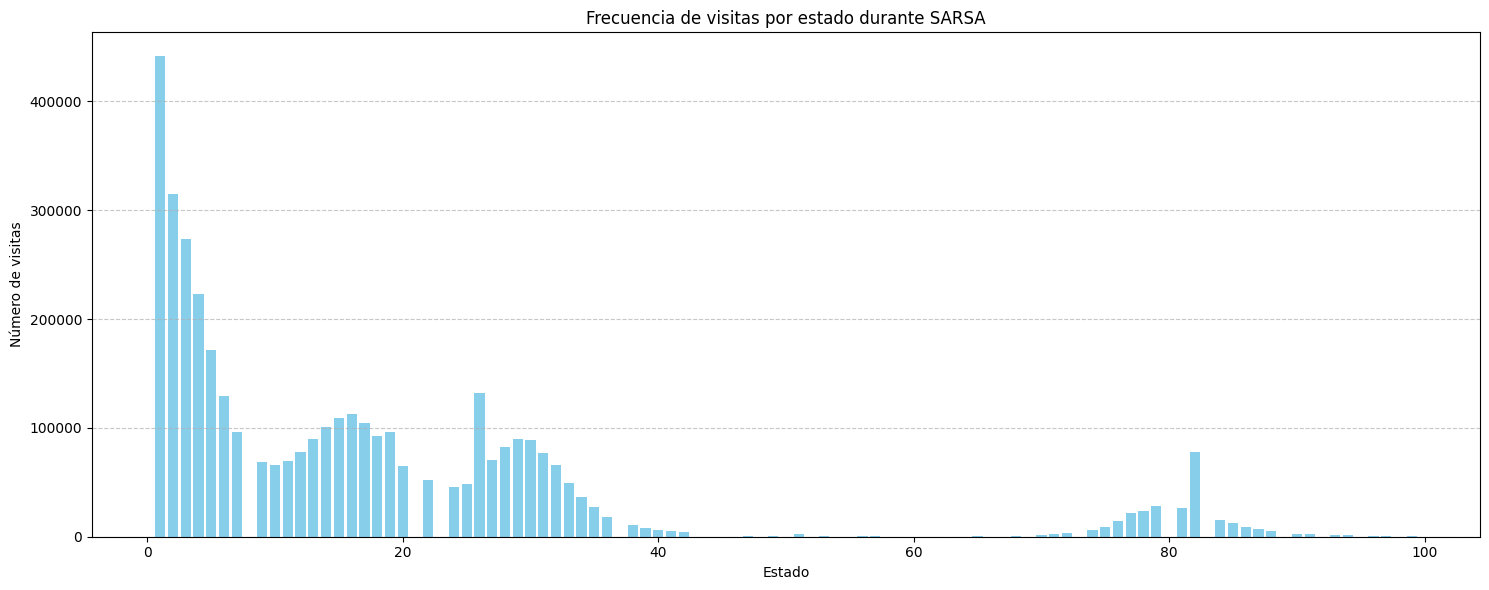

In [64]:
# Graficar
plt.figure(figsize=(15, 6))
plt.bar(dfVisitasSARSA["Estado"], dfVisitasSARSA["No. de Visitas"], color='skyblue')
plt.xlabel("Estado")
plt.ylabel("Número de visitas")
plt.title("Frecuencia de visitas por estado durante SARSA")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Se define una función, que evalúa si la política aprendida con SARSA es consistente con la política greedy derivada de la Q-table. Para cada estado del tablero (excepto los terminales definidos en gana y pierde), compara la acción sugerida por la política (accionPolitica) con la acción que maximiza el valor Q (accionGreedy). Luego, almacena en una lista de diccionarios si ambas coinciden, indicando con ¿Es consistente? si hay acuerdo. Finalmente, convierte esta lista en un DataFrame de pandas para visualizar los resultados estado por estado.

In [65]:
def verificarConsistenciaSARSA(politica, Q, gana, pierde):
    resultados = []

    for s in range(1, tamanoTablero + 1):
        if s in gana or s in pierde:
            continue

        accionesQ = Q[s]
        accionGreedy = max(accionesQ, key=accionesQ.get)
        accionPolitica = politica.get(s, None)

        resultados.append({
            'Estado': s,
            'Acción política (SARSA)': accionPolitica,
            'Acción greedy según Q': accionGreedy,
            '¿Es consistente?': accionPolitica == accionGreedy
        })

    return pd.DataFrame(resultados)

A continuación, se verifica si la política SARSA es coherente con la Q-table y muestran en un DataFrame si la acción elegida por la política coincide con la acción greedy en cada estado.

In [66]:
dfConsistencia = verificarConsistenciaSARSA(politicaOptimaSarsa, Q_sarsa, gana, pierde)
display(dfConsistencia)

,Estado,Acción política (SARSA),Acción greedy según Q,¿Es consistente?
0,1,1,1,True
1,2,-1,-1,True
2,3,-1,-1,True
3,4,-1,-1,True
4,5,-1,-1,True
...,...,...,...,...
88,95,-1,-1,True
89,96,1,1,True
90,97,1,1,True
91,98,-1,-1,True


A continuación, se verifica e imprime si la política aprendida con SARSA es consistente en todos los estados, comparando cada acción de la política con la acción greedy según la Q-table.

In [67]:
# Mostrar resultados en tabla
print("¿La política aprendida con SARSA es consistente en todos los estados?")
print(dfConsistencia["¿Es consistente?"].all())  # True si no hay inconsistencias

¿La política aprendida con SARSA es consistente en todos los estados?
True


Se define una función para generar una visualización del tablero de juego  mostrando con símbolos la política aprendida y las inconsistencias de optimalidad. El resultado se devuelve como un DataFrame que representa visualmente la política, destacando los estados donde hay errores de optimalidad.

In [68]:
def visualizarInconsistenciasSARSA(politicaOptima, dfCheck, gana, pierde):
    tablero = np.empty((10, 10), dtype=object)
    
    estadosErroneos = set(dfCheck[dfCheck["¿Es consistente?"] == False]["Estado"])

    for i in range(10):
        for j in range(10):
            if i % 2 == 0:
                estado = i * 10 + j + 1
            else:
                estado = i * 10 + (10 - j)

            if estado in gana:
                simbolo = "🎯"
            elif estado in pierde:
                simbolo = "💀"
            elif estado in estadosErroneos:
                simbolo = "❌"
            else:
                accion = politicaOptima.get(estado, "")
                if accion == -1:
                    simbolo = "⬅️"
                elif accion == 1:
                    simbolo = "➡️"
                else:
                    simbolo = ""

            tablero[9 - i, j] = simbolo

    columnas = [f"C{j+1}" for j in range(10)]
    indices = [f"F{10-i}" for i in range(10)]
    dfTableroErrores = pd.DataFrame(tablero, columns=columnas, index=indices)

    return dfTableroErrores

A continuación, se genera un tablero visual con la política aprendida y marca los errores de optimalidad con x.

In [69]:
# Visualizar tablero con símbolos x donde hay errores
dfTableroSARSA = visualizarInconsistenciasSARSA(politicaOptimaSarsa, dfConsistencia, gana, pierde)
display(dfTableroSARSA)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
F10,🎯,➡️,⬅️,➡️,➡️,⬅️,➡️,➡️,⬅️,➡️
F9,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,➡️
F8,🎯,➡️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️
F7,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,➡️,⬅️,➡️
F6,⬅️,⬅️,⬅️,➡️,➡️,⬅️,⬅️,➡️,⬅️,➡️
F5,➡️,➡️,⬅️,⬅️,💀,⬅️,➡️,⬅️,➡️,⬅️
F4,➡️,➡️,➡️,💀,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️
F3,⬅️,⬅️,💀,➡️,⬅️,➡️,➡️,➡️,➡️,⬅️
F2,⬅️,⬅️,⬅️,⬅️,➡️,➡️,➡️,➡️,➡️,➡️
F1,➡️,⬅️,⬅️,⬅️,⬅️,⬅️,➡️,⬅️,➡️,➡️


Se genera una gráfica para representar la evolución del valor máximo de Q en los estados evaluados de seguimiento durante el entrenamiento. Usan historialQ como fuente de datos, que guarda ese valor en cada episodio. La gráfica ayuda a visualizar si el algoritmo SARSA está convergiendo.

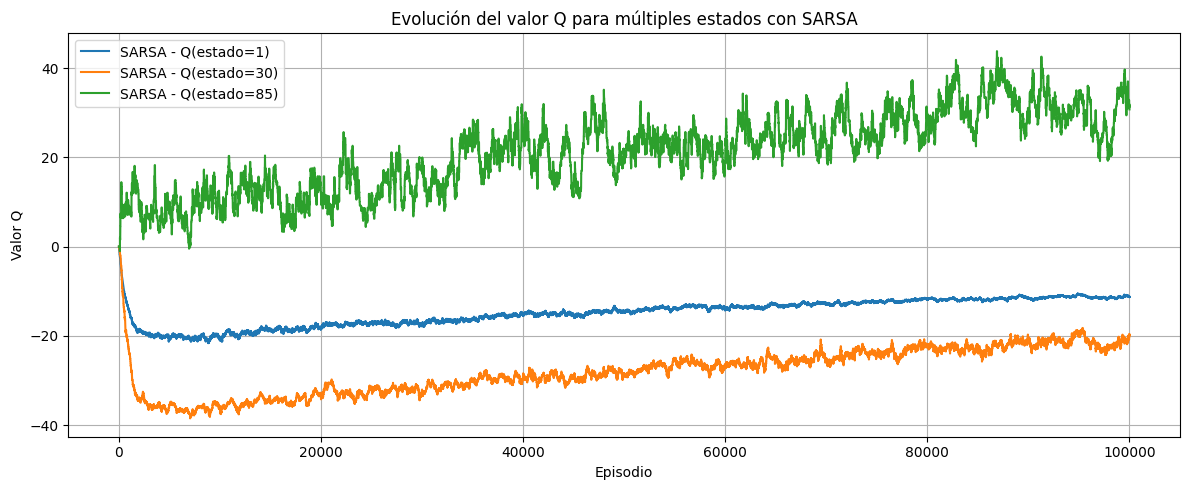

In [70]:
plt.figure(figsize=(12, 5))
for estado, valores in historialSarsa.items():
    plt.plot(valores, label=f"SARSA - Q(estado={estado})")

plt.xlabel("Episodio")
plt.ylabel("Valor Q")
plt.title("Evolución del valor Q para múltiples estados con SARSA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Se define una función para crear una visualización que represente la política óptima aprendida. Recorre todas las casillas del tablero en orden zigzag (como en el juego Escaleras y Serpientes) y asigna un símbolo a cada una.

In [71]:
def visualizarPoliticaTablero(politicaOptima, gana, pierde):
    tablero = np.empty((10, 10), dtype=object)

    for i in range(10):
        for j in range(10):
            # Zig-zag del tablero
            if i % 2 == 0:
                estado = i * 10 + j + 1
            else:
                estado = i * 10 + (10 - j)

            # Determinar símbolo para cada casilla
            if estado in gana:
                simbolo = "🎯"
            elif estado in pierde:
                simbolo = "💀"
            else:
                accion = politicaOptima.get(estado, "")
                if accion == -1:
                    simbolo = "⬅️"
                elif accion == 1:
                    simbolo = "➡️"
                else:
                    simbolo = ""

            tablero[9 - i, j] = simbolo  # invertir verticalmente

    columnas = [f"C{j+1}" for j in range(10)]
    indices = [f"F{10-i}" for i in range(10)]
    dfTablero = pd.DataFrame(tablero, columns=columnas, index=indices)

    return dfTablero

A continuación, se genera una visualización del tablero con la política óptima aprendida.

In [72]:
dfTableroSarsa = visualizarPoliticaTablero(politicaOptimaSarsa, gana, pierde)
display(dfTableroSarsa)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
F10,🎯,➡️,⬅️,➡️,➡️,⬅️,➡️,➡️,⬅️,➡️
F9,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,➡️
F8,🎯,➡️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️
F7,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,➡️,⬅️,➡️
F6,⬅️,⬅️,⬅️,➡️,➡️,⬅️,⬅️,➡️,⬅️,➡️
F5,➡️,➡️,⬅️,⬅️,💀,⬅️,➡️,⬅️,➡️,⬅️
F4,➡️,➡️,➡️,💀,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️
F3,⬅️,⬅️,💀,➡️,⬅️,➡️,➡️,➡️,➡️,⬅️
F2,⬅️,⬅️,⬅️,⬅️,➡️,➡️,➡️,➡️,➡️,➡️
F1,➡️,⬅️,⬅️,⬅️,⬅️,⬅️,➡️,⬅️,➡️,➡️


## _Punto 2:_

#### Escriba un método que implemente el algoritmo Q-Learning. La política de comportamiento debe ser un parámetro de entrada al método.

Se implementa una función que permite importar desde un archivo .csv una política de comportamiento probabilística para el agente. (proveniente de la politica soft parametrizada en el taller # 2). La función recibe como entrada el nombre del archivo y retorna un diccionario con la politica en el que cada clave corresponde a un estado (entero) y su valor asociado es otro diccionario que contiene la probabilidad de tomar cada acción posible: -1 (retroceder) y 1 (avanzar). 
Para ello, se lee el archivo con la librería de Pandas, y luego se recorre fila por fila del DataFrame para construir el diccionario completo. Finalmente, se carga la política soft desde el archivo y queda disponible para que el agente pueda usarla como política de comportamiento (piB) durante el entrenamiento.

In [41]:
def cargarPoliticaSoft(nombre_archivo="politica_soft.csv", gana=set(), pierde=set()):
    df = pd.read_csv(nombre_archivo)
    politica = {}
    for _, fila in df.iterrows():
        estado = int(fila["Estado"])
        politica[estado] = {
            -1: float(fila["Prob_-1"]),
            1: float(fila["Prob_1"])
        }
    return politica

# Cargar política
politica = cargarPoliticaSoft("politica_soft.csv")

A continuación, se convierte la política soft cargada en un DataFrame para facilitar su visualización y análisis. Primero, se construye una tabla en la que cada fila contiene un estado, la probabilidad de tomar la acción -1 (retroceder) y la probabilidad de tomar la acción 1 (avanzar), extrayendo estos valores del diccionario politica.

In [42]:
# Convertir a DataFrame para impresión
dfPolitica = pd.DataFrame([
    {
        "Estado": estado,
        "Probabilidad (-1)": probs[-1], # probabilidad de retroceder
        "Probabilidad (1)": probs[1] # probabilidad de avanzar
    }
    for estado, probs in politica.items()
])

dfPolitica = dfPolitica.sort_values(by="Estado").reset_index(drop=True)
print(dfPolitica.to_string(index=False))

 Estado  Probabilidad (-1)  Probabilidad (1)
      1           0.272325          0.727675
      2           0.760307          0.239693
      3           0.771892          0.228108
      4           0.187850          0.812150
      5           0.802431          0.197569
      6           0.366485          0.633515
      7           0.096525          0.903475
      8           0.840027          0.159973
      9           0.141050          0.858950
     10           0.455131          0.544869
     11           0.298462          0.701538
     12           0.281620          0.718380
     13           0.615954          0.384046
     14           0.357842          0.642158
     15           0.895493          0.104507
     16           0.488477          0.511523
     17           0.662882          0.337118
     18           0.142967          0.857033
     19           0.352739          0.647261
     20           0.131588          0.868412
     21           0.823579          0.176421
     22   

La siguiente función, implementa el algoritmo Q-learning en forma tabular para aprender una política óptima, considerando exploración con una estrategia ε-greedy y monitoreo del aprendizaje. Se inicializa la tabla Q con valores cero para cada acción (-1 o 1) en cada estado, un historial para registrar cómo evolucionan los valores Q en estados seleccionados, un contador de visitas por estado, y una política objetivo. 

En cada episodio, el agente inicia desde el estado 1 y elige acciones ya sea por exploración aleatoria, o por explotación. Después de calcular el nuevo estado y recompensa con, se actualiza la tabla Q con la fórmula estándar de Q-learning. Al finalizar cada episodio, se registra el valor Q actual de algunos estados monitoreados, y se reduce el epsilon para disminuir gradualmente la exploración. 

Finalmente, se construye la política óptima extrayendo, para cada estado no terminal, la acción con mayor valor Q. La función retorna la tabla Q, la política óptima aprendida, el historial de valores Q para los estados monitoreados y el conteo de visitas por estado.

La correspondencia matematica para la actualización de la función Q en la politica optima, está dada por la forma de Q-learning:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right)
$$

In [43]:
def qLearning(piB, transicionFunc):
    Q = defaultdict(lambda: {-1: 0.0, 1: 0.0})
    historial = defaultdict(list)
    visitasEstado = defaultdict(int)
    politicaOptima = {}

    epsilon = 1.0
    epsilon_min = 0.05
    epsilon_decay = 0.99999

    estadosARegistrar = [1, 30, 85]  # Estados a monitorear

    for ep in range(episodios):
        estado = 1

        while estado not in gana and estado not in pierde:
            visitasEstado[estado] += 1

            if np.random.rand() < epsilon:
                accion = np.random.choice([-1, 1])
            else:
                accion = max(Q[estado], key=Q[estado].get)

            dado = np.random.choice(np.arange(1, 7), p=probabilidades)
            nuevoEstado, recompensa = transicionFunc(estado, accion, dado, escaleras, serpientes)

            maxQNuevo = max(Q[nuevoEstado].values()) if nuevoEstado not in gana and nuevoEstado not in pierde else 0
            Q[estado][accion] += alpha * (recompensa + gamma * maxQNuevo - Q[estado][accion])

            estado = nuevoEstado

        # Guardar evolución del valor Q de los estados seleccionados
        for est in estadosARegistrar:
            if est in Q:
                historial[est].append(max(Q[est].values()))
            else:
                historial[est].append(0)

        # Decaimiento de epsilon
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    for s in range(1, tamanoTablero + 1):
        if s in gana or s in pierde:
            continue
        mejorAccion = max(Q[s], key=Q[s].get)
        politicaOptima[s] = mejorAccion

    return Q, politicaOptima, historial, visitasEstado

A continuación, se ejecuta el entrenamiento con Q-learning usando la política de comportamiento y la configuración del entorno (tablero, escaleras, serpientes, recompensas). Devuelve la Q-table aprendida, la política óptima derivada y un historial que muestra cómo evoluciona el valor Q del estado inicial durante los episodios.

In [44]:
# Ejecutar Q-learning
Q, politicaOptima, historialQ, visitas = qLearning(politica, transicionFunc=transicionRecompensa)

A continuación se genera el despliegue de la cantidad de visitas que recibió cada estado durante la ejecución del algoritmo Q-learning

In [46]:
dfVisitas = pd.DataFrame(sorted(visitas.items()), columns=["Estado", "No. de Visitas"])
display(dfVisitas)

,Estado,No. de Visitas
0,1,164607
1,2,71390
2,3,74921
3,4,77506
4,5,76544
...,...,...
68,93,1836
69,94,1255
70,96,1098
71,97,842


Ahora, se convierte el diccionario con los estados vistos, en un DataFrame ordenado por estado, y luego se genera una gráfica de barras para visualizar esa información. El gráfico muestra en el eje X los estados del tablero (del 1 al 100) y en el eje Y cuántas veces fue visitado cada uno durante la ejecución del algoritmo Q-learning.

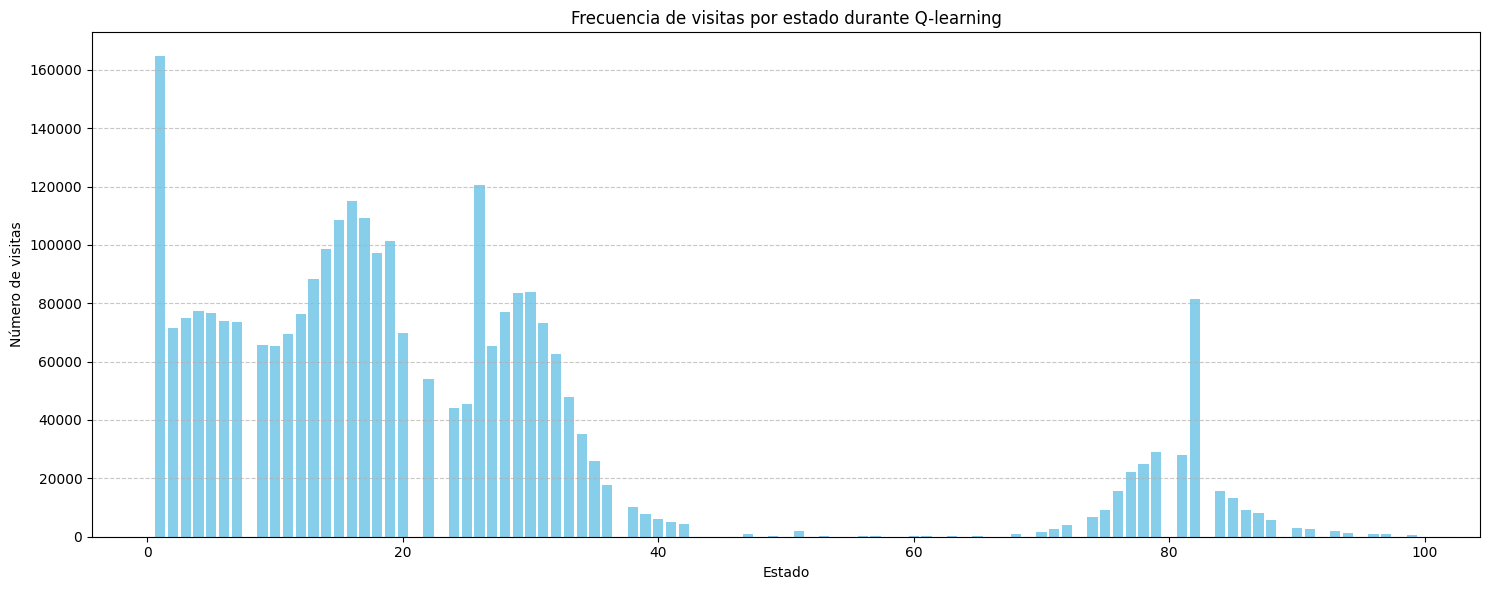

In [48]:
# Graficar
plt.figure(figsize=(15, 6))
plt.bar(dfVisitas["Estado"], dfVisitas["No. de Visitas"], color='skyblue')
plt.xlabel("Estado")
plt.ylabel("Número de visitas")
plt.title("Frecuencia de visitas por estado durante Q-learning")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

La siguiente función, evalúa si la política aprendida por el agente es óptima con respecto a los valores Q aprendidos. Recorre todos los estados del entorno, y para cada uno, compara la acción elegida por la política, con la mejor acción según la Q-table. Guarda los resultados en una lista de diccionarios que incluyen el estado, ambas acciones, y una verificación booleana de si coinciden. Luego convierte esa lista en un DataFrame para análisis detallado y determina si la política es completamente óptima, que será True solo si en todos los estados las acciones coinciden. La función retorna tanto el DataFrame como el resultado booleano.

In [50]:
def verificarOptimalidad(politica, Q, estados, gana, pierde):
    resultados = []

    for s in estados:
        if s in gana or s in pierde:
            continue

        accionesQ = Q[s]
        accionOptimaQ = max(accionesQ, key=accionesQ.get)
        accionPi = politica.get(s, None)

        resultados.append({
            'Estado': s,
            'Acción política aprendida': accionPi,
            'Acción óptima según Q': accionOptimaQ,
            '¿Es óptima?': accionPi == accionOptimaQ
        })

    dfComparacion = pd.DataFrame(resultados)
    esOptima = dfComparacion['¿Es óptima?'].all()

    return dfComparacion, esOptima

A continuación, se evalúa si la política aprendida es óptima respecto a los valores de la tabla Q. Para ello, se llama a la función verificarOptimalidad, que compara para cada estado no terminal la acción que dicta la política con la acción que maximiza Q. El resultado se almacena en un DataFrame que muestra, estado por estado,  si la política coincide con Q, y en "esOptima", un valor booleano que indica si la política es óptima en todos los estados.

In [51]:
dfCheck, esOptima = verificarOptimalidad(politicaOptima, Q, estados, gana, pierde)
display(dfCheck)
print("¿La política aprendida es óptima respecto a Q?", esOptima)

,Estado,Acción política aprendida,Acción óptima según Q,¿Es óptima?
0,1,1,1,True
1,2,1,1,True
2,3,1,1,True
3,4,1,1,True
4,5,1,1,True
...,...,...,...,...
88,95,-1,-1,True
89,96,1,1,True
90,97,1,1,True
91,98,-1,-1,True


¿La política aprendida es óptima respecto a Q? True


A continuación, se verifica si la política aprendida es óptima comparándola con la Q-table, y guarda el detalle por estado en dfCheck y el resultado general en esOptima.

In [52]:
dfCheck, esOptima = verificarOptimalidad(politicaOptima, Q, estados, gana, pierde)

Se define una función para generar una visualización del tablero de juego  mostrando con símbolos la política aprendida y los errores de optimalidad. El resultado se devuelve como un DataFrame que representa visualmente la política, destacando los estados donde hay errores de optimalidad.

In [53]:
def visualizarPoliticaConErrores(politicaOptima, dfCheck, gana, pierde):
    tablero = np.empty((10, 10), dtype=object)

    # Crear conjunto de estados con error de optimalidad
    estadosErroneos = set(dfCheck[dfCheck["¿Es óptima?"] == False]["Estado"])

    for i in range(10):
        for j in range(10):
            # Zig-zag
            if i % 2 == 0:
                estado = i * 10 + j + 1
            else:
                estado = i * 10 + (10 - j)

            if estado in gana:
                simbolo = "🎯"
            elif estado in pierde:
                simbolo = "💀"
            elif estado in estadosErroneos:
                simbolo = "❌"
            else:
                accion = politicaOptima.get(estado, "")
                if accion == -1:
                    simbolo = "⬅️"
                elif accion == 1:
                    simbolo = "➡️"
                else:
                    simbolo = ""

            tablero[9 - i, j] = simbolo

    columnas = [f"C{j+1}" for j in range(10)]
    indices = [f"F{10-i}" for i in range(10)]
    dfTableroErrores = pd.DataFrame(tablero, columns=columnas, index=indices)

    return dfTableroErrores

A continuación, se genera un tablero visual con la política aprendida y marca los errores de optimalidad con x.

In [54]:
dfTableroErrores = visualizarPoliticaConErrores(
    politicaOptima, dfCheck, gana, pierde
)
display(dfTableroErrores)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
F10,🎯,➡️,⬅️,➡️,➡️,⬅️,➡️,➡️,⬅️,➡️
F9,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,➡️
F8,🎯,⬅️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️
F7,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,➡️,⬅️,➡️
F6,➡️,⬅️,➡️,➡️,⬅️,⬅️,⬅️,⬅️,⬅️,➡️
F5,➡️,➡️,⬅️,⬅️,💀,⬅️,➡️,⬅️,➡️,⬅️
F4,➡️,➡️,➡️,💀,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️
F3,⬅️,⬅️,💀,⬅️,⬅️,➡️,➡️,➡️,➡️,⬅️
F2,⬅️,⬅️,⬅️,⬅️,➡️,➡️,➡️,➡️,➡️,➡️
F1,➡️,➡️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️


Se genera una gráfica para representar la evolución del valor máximo de Q en los estados evaluados de seguimiento durante el entrenamiento. Usan historialQ como fuente de datos, que guarda ese valor en cada episodio. La gráfica ayuda a visualizar si el algoritmo Q-learning está convergiendo.

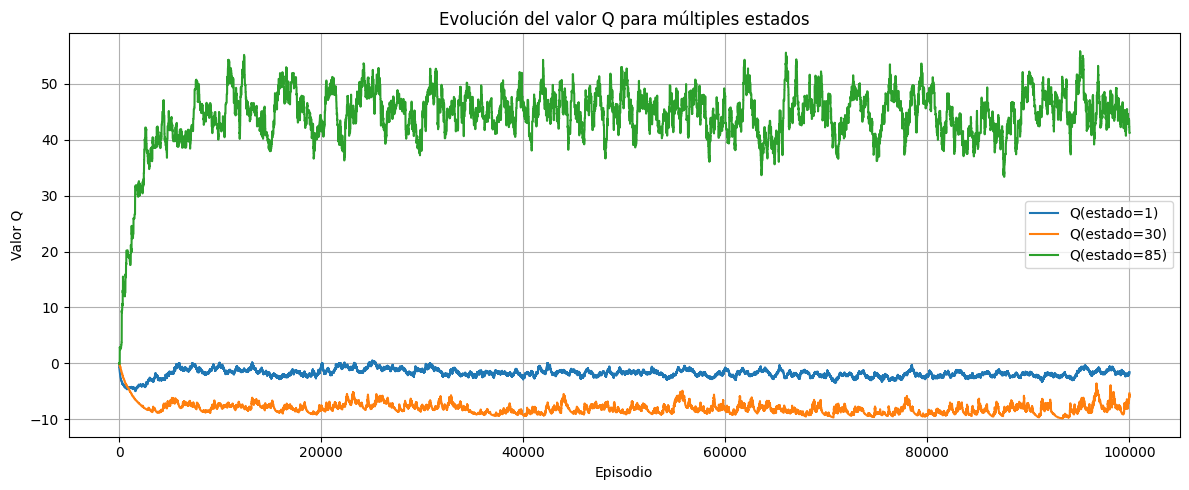

In [55]:
plt.figure(figsize=(12, 5))
for estado, valores in historialQ.items():
    plt.plot(valores, label=f"Q(estado={estado})")

plt.xlabel("Episodio")
plt.ylabel("Valor Q")
plt.title("Evolución del valor Q para múltiples estados")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Se define una función para crear una visualización que represente la política óptima aprendida. Recorre todas las casillas del tablero en orden zigzag (como en el juego Escaleras y Serpientes) y asigna un símbolo a cada una.

In [57]:
def visualizarPoliticaTablero(politicaOptima, gana, pierde):
    tablero = np.empty((10, 10), dtype=object)

    for i in range(10):
        for j in range(10):
            # Zig-zag del tablero
            if i % 2 == 0:
                estado = i * 10 + j + 1
            else:
                estado = i * 10 + (10 - j)

            # Determinar símbolo para cada casilla
            if estado in gana:
                simbolo = "🎯"
            elif estado in pierde:
                simbolo = "💀"
            else:
                accion = politicaOptima.get(estado, "")
                if accion == -1:
                    simbolo = "⬅️"
                elif accion == 1:
                    simbolo = "➡️"
                else:
                    simbolo = ""

            tablero[9 - i, j] = simbolo  # invertir verticalmente

    columnas = [f"C{j+1}" for j in range(10)]
    indices = [f"F{10-i}" for i in range(10)]
    dfTablero = pd.DataFrame(tablero, columns=columnas, index=indices)

    return dfTablero

A continuación, se genera una visualización del tablero con la política óptima aprendida.

In [58]:
# Visualizar política óptima en forma de tablero
dfPoliticaTablero = visualizarPoliticaTablero(politicaOptima, gana, pierde)
display(dfPoliticaTablero)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
F10,🎯,➡️,⬅️,➡️,➡️,⬅️,➡️,➡️,⬅️,➡️
F9,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,➡️
F8,🎯,⬅️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️
F7,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,➡️,⬅️,➡️
F6,➡️,⬅️,➡️,➡️,⬅️,⬅️,⬅️,⬅️,⬅️,➡️
F5,➡️,➡️,⬅️,⬅️,💀,⬅️,➡️,⬅️,➡️,⬅️
F4,➡️,➡️,➡️,💀,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️
F3,⬅️,⬅️,💀,⬅️,⬅️,➡️,➡️,➡️,➡️,⬅️
F2,⬅️,⬅️,⬅️,⬅️,➡️,➡️,➡️,➡️,➡️,➡️
F1,➡️,➡️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️


## _Punto 3:_

#### Utilice sus implementaciones halle políticas óptimas. Sintonice apropiadamente los hiperparámetros de cada algoritmo. Compare las políticas en 1000 partidas del juego.

Estaba pensando en aqui probar por ejemplo en el punto 2, politicas de comportamiento "uniformes" (50% para la izquierda y 50% para la derecha), y comparar los resultados.

Con el punto 1, de pronto probar cambiando los hiperparametros.

Por favor revisalo y me cuentas!!

## _Punto 4:_

#### Análisis de resultados.